# Using Sea Surface Temperature to monitor ocean surface warming
### *How well do different satellite SST trend estimates compare with each other?*
This notebook aims to evaluate the reliability and representativeness of sea surface temperature (SST) linear trends in satellite-based long-term climate data records (CDRs). 
To this end, two different SST CDRs have been intercompared over a common 30-year long period (1982-2011). These datasets, available from the CADS, are the following:

- Sea surface temperature daily gridded data from 1981 to 2016 derived from a multi-product satellite-based ensemble - from the Group for High-Resolution Sea Surface Temperature (GHRSST) multi-product ensemble (GMPE) produced by the European Space Agency SST Climate Change Initiative (ESA SST CCI) (GMPE in the following);
- Sea Surface Temperature daily data from 1981 to present derived from satellite observations, ESA CCI SST Level-4 dataset v2.1 (ESA CCI SST in the following);

#### **Main Takeaways - Assessment outcomes in a nutshell**
- Both datasets correctly capture the long-term SST trend at both global and regional scale;
 							
- The spatial pattern of the SST trend evidences that the Northern Hemisphere is experiencing a more intense warming compared to  the Southern Hemisphere, as reported in literature (Yang et al. 2021; Kang et al, 2015);
 							
- ESA CCI tends to exhibit higher trend estimates compared to GMPE, which serves as a reference dataset due to its nature, particularly in certain ocean basins like the Tropical Atlantic and Northern Indian Ocean;
 							
- On average, the global mean SST trend estimates provided by the two datasets are consistent within the 95% confidence interval;


## Import packages

In [1]:
import tempfile

import cacholote
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import tqdm
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot, utils, diagnostics
from xarrayMannKendall import Mann_Kendall_test

plt.style.use("seaborn-v0_8-notebook")

## Define Parameters

In [2]:
# Time
year_start = 1982
year_stop = 2011

# Choose timeseries
seasonal = False
assert isinstance(seasonal, bool)

## Define Parameters

In [3]:
# Requests
request_dicts = {
    "ESACCI": {
        "collection_id": "satellite-sea-surface-temperature",
        "request": {
            "processinglevel": "level_4",
            "format": "zip",
            "variable": "all",
            "sensor_on_satellite": "combined_product",
            "version": "2_1",
        },
        "chunks": {"year": 1, "month": 1},
    },
    "GMPE": {
        "collection_id": "satellite-sea-surface-temperature-ensemble-product",
        "request": {
            "format": "zip",
            "variable": "all",
        },
        "chunks": {"year": 1, "month": 1, "day": 12},  # CDS limit is 12
    },
}

# Parameters to speed up I/O
open_mfdataset_kwargs = {
    "concat_dim": "time",
    "combine": "nested",
    "data_vars": "minimal",
    "coords": "minimal",
    "compat": "override",
    "parallel": True,
}

## Functions to cache

In [4]:
def get_masked_sst(ds):
    da = ds["analysed_sst"]
    if "mask" in ds:
        da = da.where(ds["mask"] == 1)
    with xr.set_options(keep_attrs=True):
        da -= 273.15
    da.attrs["units"] = "°C"
    return da


def add_chunksizes(da):
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da


def rechunk(obj):
    """Use NetCDF chunks."""
    chunks = {"time": 1, "year": 1, "season": 1, "latitude": 1_200, "longitude": 2_400}
    obj = obj.chunk(
        **{dim: chunksize for dim, chunksize in chunks.items() if dim in obj.dims}
    )
    if isinstance(obj, xr.DataArray):
        return add_chunksizes(obj)
    for da in obj.data_vars.values():
        add_chunksizes(da)
    return obj


def compute_low_resolution(ds, freq):
    ds = rechunk(ds)
    da = get_masked_sst(ds)
    target_sizes = {"latitude": 720, "longitude": 1440}
    coarsen_dims = {
        dim: ratio
        for dim, target_size in target_sizes.items()
        if (ratio := da.sizes[dim] // target_size) > 1
    }
    with xr.set_options(keep_attrs=True):
        if coarsen_dims:
            da = da.coarsen(coarsen_dims).mean()
        da = da.sortby("time").resample(time=freq).mean()
    for coord in da.coords:
        da[coord].attrs = ds[coord].attrs
    return rechunk(da).to_dataset()


def _mann_kendall(da, **kwargs):
    da = da.chunk({dim: -1 if dim == "time" else "auto" for dim in da.dims})
    coords_name = {"time": "time", "x": "longitude", "y": "latitude"}
    with tempfile.TemporaryDirectory() as tmpdir:
        da.to_zarr(tmpdir)
        da = xr.open_dataarray(tmpdir, engine="zarr", chunks=dict(da.chunksizes))
        ds_trend = Mann_Kendall_test(da, coords_name=coords_name, **kwargs).compute()

    ds_trend = ds_trend.rename({k: v for k, v in coords_name.items() if k != "time"})
    for coord in ds_trend.coords:
        ds_trend[coord].attrs = da[coord].attrs
    ds_trend["trend"].attrs["long_name"] = f"Trend of {da.attrs['long_name']}"
    return ds_trend


@cacholote.cacheable
def compute_mann_kendall_trend(
    collection_id,
    request,
    chunks,
    year_start,
    year_stop,
    seasonal,
    open_mfdataset_kwargs,
    **mann_kendall_kwargs,
):
    dataarrays = []
    for year in tqdm.tqdm(range(year_start, year_stop + 1), desc="annual"):
        requests = download.update_request_date(
            request, start=f"{year-1}-12", stop=f"{year}-11", stringify_dates=True
        )
        ds = download.download_and_transform(
            collection_id=collection_id,
            requests=requests,
            chunks=chunks,
            transform_chunks=False,
            transform_func=compute_low_resolution,
            transform_func_kwargs={"freq": "Q-DEC" if seasonal else "MS"},
            **open_mfdataset_kwargs,
        )
        dataarrays.append(rechunk(ds["analysed_sst"]))
    da = xr.concat(dataarrays, "time")

    if seasonal:
        ds = da.groupby("time.season").map(_mann_kendall, **mann_kendall_kwargs)
        ds["trend"].attrs["units"] = f"{da.attrs['units']}/year"
    else:
        ds = da.groupby("time.year").map(_mann_kendall, **mann_kendall_kwargs)
        ds["trend"].attrs["units"] = f"{da.attrs['units']}/year"
    return rechunk(ds)

## Download and transform

In [5]:
datasets = []
for product, request_dict in request_dicts.items():
    #print(f"{product=}")
    ds = compute_mann_kendall_trend(
        **request_dict,
        year_start=year_start,
        year_stop=year_stop,
        seasonal=seasonal,
        open_mfdataset_kwargs=open_mfdataset_kwargs,
        # Mann Kendall settings
        alpha=0.05,
        method="theilslopes",
    )
    for coord in ("longitude", "latitude"):
        ds[coord] = ds[coord].round(3)
    ds = ds.expand_dims(product=[product])
    datasets.append(rechunk(ds))
ds = xr.concat(datasets, "product")

## Plot Maps

ESACCI in Mediterranean Sea: 0.05 ± 0.03 °C/year
ESACCI in Baltic Sea: 0.09 ± 0.07 °C/year
ESACCI in Black Sea: 0.07 ± 0.04 °C/year
ESACCI in Tropical Atlantic: 0.04 ± 0.01 °C/year
ESACCI in Northern Indian Ocean: 0.03 ± 0.01 °C/year
GMPE in Mediterranean Sea: 0.05 ± 0.03 °C/year
GMPE in Baltic Sea: 0.06 ± 0.04 °C/year
GMPE in Black Sea: 0.07 ± 0.04 °C/year
GMPE in Tropical Atlantic: 0.03 ± 0.01 °C/year
GMPE in Northern Indian Ocean: 0.02 ± 0.01 °C/year


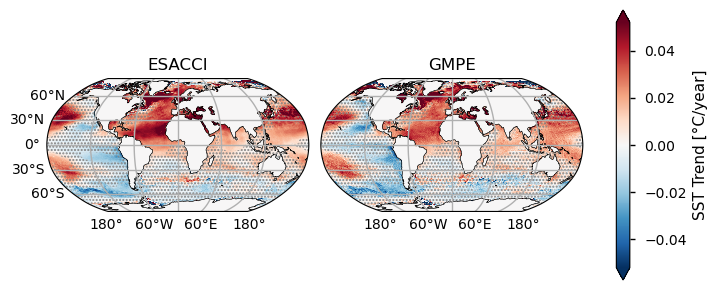

In [6]:
import numpy as np
plt.rcParams.update({'hatch.color': 'grey'})
projection = ccrs.Robinson()
facet = plot.projected_map(
    ds["trend"]*12,
    projection=projection,
    row="season" if "season" in ds.dims else None,
    col="product",
    robust=True,
    center=0,
    cbar_kwargs={'label': 'SST Trend [°C/year]'}
)
med_sea = [30,46,-6,36]
baltic_sea = [53,66,10,30]
black_sea = [39,48,26,42]
tropAtl = [0,30,-60,0]
NorthInd = [10,30,60,80]
regions = [med_sea, baltic_sea, black_sea, tropAtl, NorthInd]
regnames = ['Mediterranean Sea', 'Baltic Sea', 'Black Sea', 'Tropical Atlantic', 'Northern Indian Ocean']
for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
    p_value = ds["p"].sel(**sel_dict).reset_coords(drop=True)
    plot.projected_map(
        p_value.where(p_value!=1),
        projection=projection,
        show_stats=False,
        ax=ax,
        cmap="none",
        add_colorbar=False,
        plot_func="contourf",
        levels=[0, 0.05, 1],
        hatches=["", "." * 5],
    )
    for r, rname in zip(regions, regnames):
        p_reg = ds["p"].sel(**sel_dict).reset_coords(drop=True).sel(latitude=slice(r[0], r[1]), longitude=slice(r[2], r[3]))
        p_reg = p_reg.where(p_reg<=0.5)
        t_reg = ds["trend"].sel(**sel_dict).reset_coords(drop=True).sel(latitude=slice(r[0], r[1]), longitude=slice(r[2], r[3])).where(p_reg<=0.05)*12
        t_reg_avg = t_reg.weighted(np.cos(t_reg.latitude*np.pi/180.)).mean(['latitude', 'longitude'])
        p_reg_avg = p_reg.weighted(np.cos(p_reg.latitude*np.pi/180.)).mean(['latitude', 'longitude'])
        z = -0.862 + (0.743 -2.404*np.log(p_reg_avg))**0.5
        SE = ((t_reg_avg / z)**2)**0.5
        print(f"{str(sel_dict['product'])} in {rname}: {t_reg_avg.values:.1} ± {SE.values:.1} °C/year")
    ax.set_title(str(sel_dict['product']))


The global SST trend map has been computed over 30 years from 1982 to 2011 at the 95% confidence level (grey dots mark non-significant trend areas). SST exhibits an overall positive (warming) trend over the Northern Hemisphere, where it can reach $\simeq$0.05 °C/year, while the Southern Hemisphere is characterized by less significant and negative values. A large area covering the Eastern Pacific Ocean is characterized by no significant trends (i.e., p $\geq$ 0.05) with few sparse significant values in both ESA CCI and GMPE. The North Atlantic ocean and the European seas stand out showing the most intense SST trend values, as e.g. the Mediterranean Sea (GMPE = 0.05 $\pm$ 0.03 °C/year, ESA CCI = 0.05 $\pm$ 0.03 °C/year), Baltic Sea (GMPE = 0.06 $\pm$ 0.04 °C/year, ESA CCI = 0.09$\pm$ 0.07 °C/year) and Black Sea (GMPE = 0.07 $\pm$ 0.04 °C/year, ESA CCI = 0.07 $\pm$ 0.04 °C/year). The Mediterranean SST trend is in good agreement with the one reported in Pisano et al. (2020), while Baltic Sea and Black Sea trends are similar to those found in Mulet et al. (2018), but over a shorter period. In the Black Sea, trends estimates between ESA CCI and GMPE are more in agreement than in the other two basins.


## Seasonal Trends

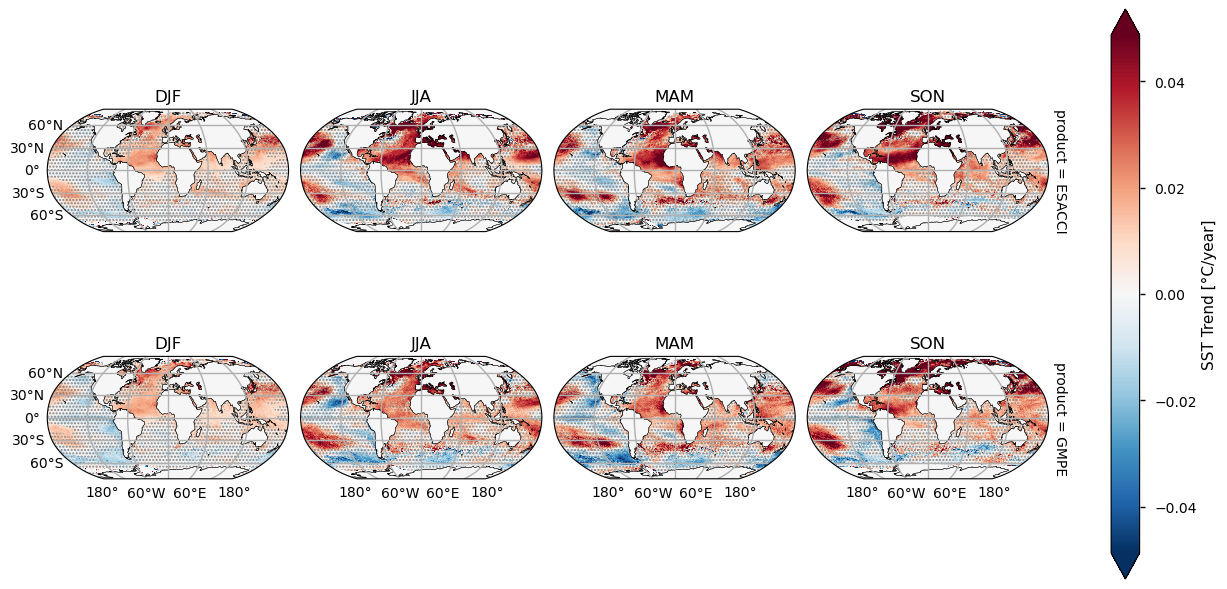

In [7]:
# Choose timeseries
seasonal = True
assert isinstance(seasonal, bool)
datasets = []
for product, request_dict in request_dicts.items():
    #print(f"{product=}")
    ds = compute_mann_kendall_trend(
        **request_dict,
        year_start=year_start,
        year_stop=year_stop,
        seasonal=seasonal,
        open_mfdataset_kwargs=open_mfdataset_kwargs,
        # Mann Kendall settings
        alpha=0.05,
        method="theilslopes",
    )
    for coord in ("longitude", "latitude"):
        ds[coord] = ds[coord].round(3)
    ds = ds.expand_dims(product=[product])
    datasets.append(rechunk(ds))
ds = xr.concat(datasets, "product")
# Plot seasonal trends
projection = ccrs.Robinson()
facet = plot.projected_map(
    ds["trend"],
    projection=projection,
    col="season" if "season" in ds.dims else None,
    row="product",
    robust=True,
    center=0,
    cbar_kwargs={'label': 'SST Trend [°C/year]'}
)
for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
    p_value = ds["p"].sel(**sel_dict).reset_coords(drop=True)
    plot.projected_map(
        p_value.where(p_value!=1),
        projection=projection,
        show_stats=False,
        ax=ax,
        cmap="none",
        add_colorbar=False,
        plot_func="contourf",
        levels=[0, 0.05, 1],
        hatches=["", "." * 5],
    )
    ax.set_title(str(sel_dict['season']))

Seasonal maps show an intensification of the trend from Spring to Autumn and an attenuation during winter. Overall the agreement between GMPE and ESA CCI SST is quite good though the former dataset provides less intense trend estimates. Both datasets’ estimates yield a Northern Hemisphere which has warmed up at a higher rate than the Southern Hemisphere, especially in Boreal Summer and Fall.
					
				
The globally averaged mean trend is estimated in 0.008 $\pm$ 0.002 °C/year for GMPE, while for ESACCI we have 0.009 $\pm$ 0.002 °C/year, which corresponds to an average total increase of about 0.24 °C in GMPE and 0.27 °C in ESACCI over this 30-year period. Within the 95% confidence interval, both datasets provide consistent estimates of global warming trends. These values are also consistent (within respective errors) with the mean global trend estimate of 0.011 °C/year from 1980 to 2005 as reported in one of the last IPCC reports (Pachauri et al., 2014). Regionally, estimates of trend slopes yield values for the Northern Indian Ocean (GMPE=0.016 $\pm$ 0.005 °C/year, ESACCI=0.028 $\pm$ 0.006 °C/year) and Tropical Atlantic (GMPE= 0.026 $\pm$ 0.006 °C/year, ESACCI=0.036 $\pm$ 0.008 °C/year), which are consistent with each others in the limits of their respective uncertainties, though are areas of main disagreement for trend estimates.
	


## SST Time series and trends over Tropical Atlantic and Northern Indian Ocean ##
Trend analyses shown in the previous section evidenced the existence of disagreement areas between ESA-CCI and GMPE SST datasets. In particular, the Northern Indian Ocean and the   Tropical Atlantic exhibit a larger SST trend for the ESA-CCI dataset, when compared to GMPE. The ESA-CCI and GMPE SST monthly time series were then intercompared in those areas, in order to have further insights on these discrepancies. 


In [8]:
import pymannkendall as mk
import numpy as np
# Regions
regions = {
    "global": {"lon_slice": slice(-180, 180), "lat_slice": slice(-90, 90)},
    "northern hemisphere": {"lon_slice": slice(-180, 180), "lat_slice": slice(0, 90)},
    "southern hemisphere": {"lon_slice": slice(-180, 180), "lat_slice": slice(-90, 0)},
    "med sea": {"lon_slice": slice(med_sea[2], med_sea[3]), "lat_slice": slice(med_sea[0], med_sea[1])},
    "baltic sea": {"lon_slice": slice(baltic_sea[2], baltic_sea[3]), "lat_slice": slice(baltic_sea[0], baltic_sea[1])},
    "black sea": {"lon_slice": slice(black_sea[2], black_sea[3]), "lat_slice": slice(black_sea[0], black_sea[1])},
    "Tropical Atlantic": {"lon_slice": slice(-60, 0), "lat_slice": slice(0,30)},
    "Northern Indian Ocean": {"lon_slice": slice( 60, 80), "lat_slice": slice(10,30)},
}

def get_masked_sst(ds):
    da = ds["analysed_sst"]
    if "mask" in ds:
        da = da.where(ds["mask"] == 1)
    with xr.set_options(keep_attrs=True):
        da -= 273.15
    da.attrs["units"] = "°C"
    return da


def add_chunksizes(da):
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da


def rechunk(obj):
    """Use NetCDF chunks."""
    chunks = {"time": 1, "year": 1, "season": 1, "latitude": 1_200, "longitude": 2_400}
    obj = obj.chunk(
        **{dim: chunksize for dim, chunksize in chunks.items() if dim in obj.dims}
    )
    if isinstance(obj, xr.DataArray):
        return add_chunksizes(obj)
    for da in obj.data_vars.values():
        add_chunksizes(da)
    return obj


def compute_regionalised_spatial_weighted_mean(ds, lon_slice, lat_slice):
    ds = rechunk(ds)
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    da = get_masked_sst(ds)
    return diagnostics.spatial_weighted_mean(da, weights=True).to_dataset()

datasets = []
for product, request_dict in request_dicts.items():
    for region, slices in regions.items():
        print(f"{product=} {region=}")
        for year in tqdm.tqdm(range(year_start, year_stop + 1), desc="year"):
            requests = download.update_request_date(
                request_dict["request"],
                start=f"{year-1}-12",
                stop=f"{year}-11",
                stringify_dates=True,
            )
            ds = download.download_and_transform(
                collection_id=request_dict["collection_id"],
                requests=requests,
                chunks=request_dict["chunks"],
                transform_chunks=False,
                transform_func=compute_regionalised_spatial_weighted_mean,
                transform_func_kwargs=slices,
                **open_mfdataset_kwargs,
            )
            datasets.append(ds.expand_dims(product=[product], region=[region]))
da = xr.merge(datasets)["analysed_sst"].compute()
del datasets

product='ESACCI' region='global'


year: 100%|██████████| 30/30 [00:03<00:00,  8.44it/s]


product='ESACCI' region='northern hemisphere'


year: 100%|██████████| 30/30 [00:02<00:00, 10.60it/s]


product='ESACCI' region='southern hemisphere'


year: 100%|██████████| 30/30 [00:02<00:00, 12.82it/s]


product='ESACCI' region='med sea'


year: 100%|██████████| 30/30 [00:03<00:00,  8.43it/s]


product='ESACCI' region='baltic sea'


year: 100%|██████████| 30/30 [00:03<00:00,  9.12it/s]


product='ESACCI' region='black sea'


year: 100%|██████████| 30/30 [00:02<00:00, 13.42it/s]


product='ESACCI' region='Tropical Atlantic'


year: 100%|██████████| 30/30 [00:01<00:00, 17.95it/s]


product='ESACCI' region='Northern Indian Ocean'


year: 100%|██████████| 30/30 [00:01<00:00, 19.17it/s]


product='GMPE' region='global'


year: 100%|██████████| 30/30 [00:01<00:00, 15.92it/s]


product='GMPE' region='northern hemisphere'


year: 100%|██████████| 30/30 [00:01<00:00, 16.62it/s]


product='GMPE' region='southern hemisphere'


year: 100%|██████████| 30/30 [00:02<00:00, 13.98it/s]


product='GMPE' region='med sea'


year: 100%|██████████| 30/30 [00:02<00:00, 13.27it/s]


product='GMPE' region='baltic sea'


year: 100%|██████████| 30/30 [00:01<00:00, 15.56it/s]


product='GMPE' region='black sea'


year: 100%|██████████| 30/30 [00:02<00:00, 13.61it/s]


product='GMPE' region='Tropical Atlantic'


year: 100%|██████████| 30/30 [00:01<00:00, 16.30it/s]


product='GMPE' region='Northern Indian Ocean'


year: 100%|██████████| 30/30 [00:01<00:00, 18.73it/s]


/data/wp5/.tmp/ipykernel_828/4092050061.py:2: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for region, da_region in da.groupby("region"):
/data/wp5/.tmp/ipykernel_828/4092050061.py:5: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for color, (product, da_product) in zip(colors, da_region.groupby("product")):
/data/common/miniforge3/envs/wp5/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/data/common/miniforge3/envs/wp5/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Group

ESACCI in Northern Indian Ocean: 0.0024 ± 0.0006 °C/year
GMPE in Northern Indian Ocean: 0.0014 ± 0.0006 °C/year


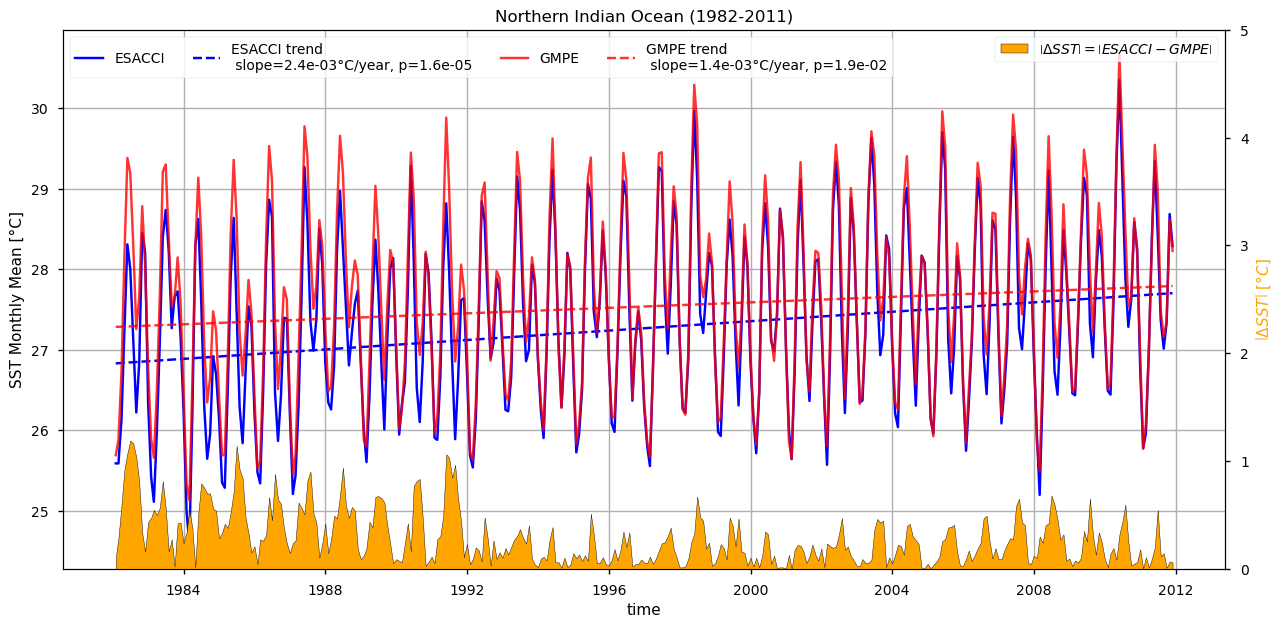

/data/wp5/.tmp/ipykernel_828/4092050061.py:5: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for color, (product, da_product) in zip(colors, da_region.groupby("product")):
/data/common/miniforge3/envs/wp5/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/data/common/miniforge3/envs/wp5/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


ESACCI in Tropical Atlantic: 0.0032 ± 0.0005 °C/year
GMPE in Tropical Atlantic: 0.0026 ± 0.0005 °C/year


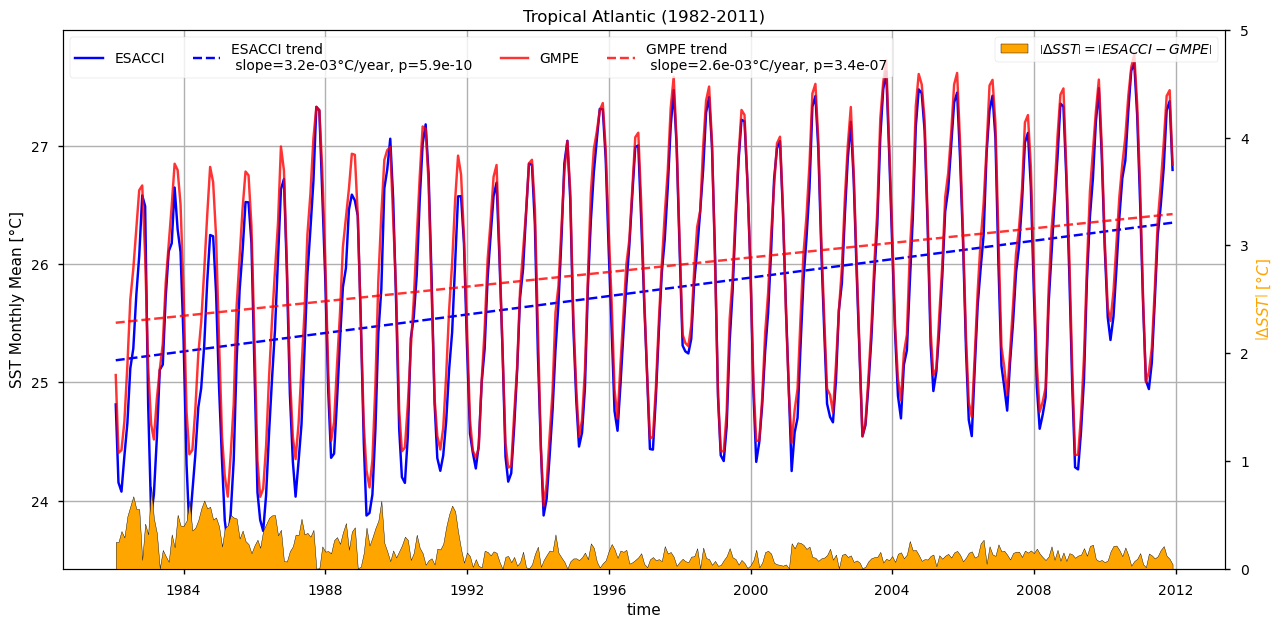

In [11]:
colors = ["blue", "red"]
for region, da_region in da.groupby("region"):
    if region.title()=="Tropical Atlantic" or region.title()=="Northern Indian Ocean":
        fig, ax = plt.subplots(figsize=(15,7))
        for color, (product, da_product) in zip(colors, da_region.groupby("product")):
            da_product = da_product.resample(time='1M').mean().isel(time=slice(1, None)) #Originally was time='1Y' 20/03/2024
            if product=='GMPE':
                alpha=0.8
                diff = ((da_ref - da_product)**2)**0.5
                Ax = ax.twinx()
                Ax.fill_between(da_product['time'], 0., diff, color='orange', edgecolor='k', label=r'$\left|\Delta SST\right|= \left|ESACCI - GMPE\right|$')
                Ax.set_ylim(0., 5.)
                Ax.set_ylabel(r'$\left|\Delta SST\right| ~ [°C]$', color='orange')
            else:
                alpha=1.
                da_ref = da_product
            da_product.plot(ax=ax, label=product, color=color, alpha=alpha)
            trend, h, p, z, tau, s, var_s, slope, intercept = mk.original_test(da_product)
            ax.plot(
                da_product["time"],
                np.arange(da_product.sizes["time"]) * slope + intercept,
                label=f"{product} trend \n {slope=:.1e}°C/year, {p=:.1e}",
                color=color,
                ls="--",
                alpha=alpha,
            )
            ax.set_ylabel('SST Monthly Mean [°C]')
            ax.set_title(f"{region.title()} ({year_start}-{year_stop})")
            z = -0.862 + (0.743 -2.404*np.log(p))**0.5
            SE = ((slope / z)**2)**0.5
            print(f"{product} in {region.title()}: {slope:.2} ± {SE:.1} °C/year")
        ax.legend(loc='upper left', ncol=4)
        Ax.legend(loc='upper right')
        ax.grid()
        plt.show()

In the 1982-1991 decade, the ESA-CCI SSTs are generally colder than the GMPE ones, as sketched by the monthly time series presented in this section. This is also highlighted by the ∆SST time series (given in yellow), whose values can reach 1°C/0.6°C in the Indian Ocean and Tropical Atlantic, respectively, in the aforementioned temporal window. Such discrepancies are significantly reduced afterwards, thus resulting in a larger SST slope from the ESA-CCI CDR, when compared with GMPE.  This is a known issue of the ESA-CCI dataset, as reported in Merchant et al 2019: unscreened dust events caused negative biases in the Advanced Very High Resolution Radiometer (AVHRR) SSTs in the north East Tropical Atlantic and in the Arabian/Red Sea. This issue  covers the first decade of the CDR, resulting in anomalously high positive SST trends in these regions. 	

#### ***Some References***
- *Kang, S.M., Seager, R., Frierson, D.M.W. et al. Croll revisited: Why is the northern hemisphere warmer than the southern hemisphere?. Clim Dyn 44, 1457–1472 (2015). https://doi.org/10.1007/s00382-014-2147-z*
  
- *Merchant, C. J., Embury, O., Bulgin, C. E., Block, T., Corlett, G. K., Fiedler, E., ... & Donlon, C. (2019). Satellite-based time-series of sea-surface temperature since 1981 for climate applications. Scientific data, 6(1), 223*
  
- *Mulet, S., Buongiorno Nardelli, B., Good, S., Pisano, A., Greiner, E., Monier, M., Autret, E., Axell, L., Boberg, F., Ciliberti, S., Drévillon, M., Droghei, R., Embury, O., Gourrion, J., Høyer, J., Juza, M., Kennedy, J., Lemieux-Dudon, B., Peneva, E., Reid, R., Simoncelli, S., Storto, A., Tinker, J., Von Schuckmann, K., Wakelin, S. L., 2018. Ocean temperature and salinity. In: Copernicus Marine Service Ocean State Report, Issue 2, Journal of Operational Oceanography, 11:sup1, s5–s13, DOI: 10.1080/1755876X.2018.1489208*
- *Pachauri, R. K., Allen, M. R., Barros, V. R., Broome, J., Cramer, W., Christ, R., Church, J. A., Clarke, L., Dahe, Q., Dasgupta, P., Dubash, N. K., et al.: Climate Change 2014: Synthesis Report. Contribution of Working Groups I, II and III to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change, edited by: Pachauri, R. and Meyer, L., Geneva, Switzerland, IPCC, ISBN 978-92-9169-143-2, 2014*
   				
- *Pisano, A., Marullo, S., Artale, V., Falcini, F., Yang, C., Leonelli, F. E., Santoleri, R. and Buongiorno Nardelli, B.: New Evidence of Mediterranean Climate Change and Variability from Sea Surface Temperature Observations, Remote Sens., 12(1), 132, doi:10.3390/rs12010132, 2020*
  
- *Yang, C., Leonelli, F. E., Marullo, S., Artale, V., Beggs, H., Nardelli, B. B., ... & Pisano, A. (2021). Sea surface temperature intercomparison in the framework of the Copernicus Climate Change Service (C3S). Journal of Climate, 34(13), 5257-5283*
